The given input data file is too huge to load it in github and load here, hence making use of Google drive service to load the file. It asks for 
authentication each time.


In [113]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


import necessary libraries

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import h5py
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore
from sklearn import metrics
from keras.utils import np_utils
import matplotlib.pyplot as plt
from random import shuffle
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

Once the google drive file is mounted then the corresponding given input file is loaded on Dataframe.

In [115]:
file = h5py.File('/content/gdrive/My Drive/SVHN_single_grey1.h5','r')
#list down the keys from the h5 file
list(file.keys())

['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']

Fetching the values from h5 file

In [0]:
[X_train, y_train, X_val, y_val, X_test, y_test ]= [file['X_train'], file['y_train'], file['X_val'], file['y_val'], file['X_test'], file['y_test']]

In [117]:
print("###############Checking the Shape of each dataset received ###############")
print('X_Train Shape: ',X_train.shape)
print('y_Train Shape: ',y_train.shape)
print('X_Validation Shape: ',X_val.shape)
print('y_Validation Shape: ',y_val.shape)
print('X_Test Shape: ',X_test.shape)
print('y_Test Shape: ',y_test.shape)

###############Checking the Shape of each dataset received ###############
X_Train Shape:  (42000, 32, 32)
y_Train Shape:  (42000,)
X_Validation Shape:  (60000, 32, 32)
y_Validation Shape:  (60000,)
X_Test Shape:  (18000, 32, 32)
y_Test Shape:  (18000,)


Reshape the input data (flatten the 32x32 image sizes to 1024)

In [0]:
X_train = np.array(X_train).reshape(42000,1024)
X_val = np.array(X_val).reshape(60000,1024)
X_test = np.array(X_test).reshape(18000,1024)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Implementing Simple K-Nearest Neighbors classifier for Image Classification

In [0]:
model = KNeighborsClassifier(n_neighbors= 3 , weights = 'distance' )

Converting to Z-scores to ensure all the input records are standardized

In [0]:
X_train_z = zscore(X_train)
X_val_z = zscore(X_val)
X_test_z = zscore(X_test)

Fit the model with Training data

In [121]:
model.fit(X_train_z,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')

With the original size of given Test set the GPU was taking lot of time to predict since the number of attributes are 1024 and 18K test records.
K-nearest algorithm has to determine the distances for test data during the prediction time. This is one of the reason it is not perferred for Image Classifications
in real time where when the users try to predict something during runtime on Production it will take lot of time. Hence taking the subset for simplification,so that the classification metrics can be derived.

In [122]:
X_test_z_subset = X_test_z[17500:]
y_test_subset = y_test[17500:]
print(X_test_z_subset.shape)
print(y_test_subset.shape)

(500, 1024)
(500,)


Predicting the labels for subset of test data

In [0]:
y_predict = model.predict(X_test_z_subset)

Deriving the Classification metrics

In [0]:
score = model.score(X_test_z_subset, y_test_subset)
precision_Kmean, recall_Kmean,fscore_Kmean,support_Kmean = metrics.precision_recall_fscore_support(y_test_subset, y_predict, average='weighted')

In [125]:
print("Precision:", precision_Kmean, "\nRecall:", recall_Kmean, "\nfScore:", fscore_Kmean, "\nSupport: " , support_Kmean)

Precision: 0.46726604551888157 
Recall: 0.464 
fScore: 0.4629475447667764 
Support:  None


In [126]:
y_predict = model.predict(X_test_z_subset)
cm_Kmean = confusion_matrix(y_test_subset, y_predict)
print(cm_Kmean)

[[32  1  1  1  2  2  8  2  4  5]
 [ 0 34  6  3  7  5  2  0  2  2]
 [ 4  3 20  3  3  1  2  5  1  5]
 [ 3  3  2 26  4 11  5  2  5  3]
 [ 0  4  3  1 19  1  1  0  3  2]
 [ 3  3  1 10  2 15  5  1 10  2]
 [ 6  4  1  2  1  1 21  1  4  1]
 [ 0  7  4  2  0  1  1 21  1  1]
 [ 0  2  0  3  1  6  8  2 22  5]
 [13  2  2  1  3  3  4  2  3 22]]


Implementing Fully Connected Linear Neural Network 
With the code reference from the videos.

Fully Connected Layer (Linear Layer)

In [0]:
class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None        

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

Rectified Linear Activation Layer (ReLU) which takes the argmax(0,input)


In [0]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

softmax function to derive the proability distribution of given input

In [0]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

Cross Entropy Loss

In [0]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

Loading the Image Classficiation dataset

In [131]:
#normalize inputs from 0-255 to 0-1
X_train = X_train / 255.0
X_val = X_test / 255.0
y_val = y_test
y_train = y_train
print(X_train.shape)

(42000, 1024)


In [132]:
#verify X_train converted as 0-1
X_train

array([[0.12968785, 0.11866706, 0.10530196, ..., 0.19477727, 0.19942354,
        0.20799099],
       [0.34101608, 0.3414451 , 0.34656274, ..., 0.29498273, 0.30054745,
        0.31092745],
       [0.48284313, 0.49356118, 0.47872823, ..., 0.36837214, 0.41093138,
        0.44637334],
       ...,
       [0.6042902 , 0.61100274, 0.6149663 , ..., 0.52993256, 0.53592   ,
        0.5398412 ],
       [0.8137075 , 0.8176286 , 0.8353796 , ..., 0.83974785, 0.8319055 ,
        0.820142  ],
       [0.37285647, 0.37677765, 0.39246237, ..., 0.5414914 , 0.5509529 ,
        0.5509529 ]], dtype=float32)

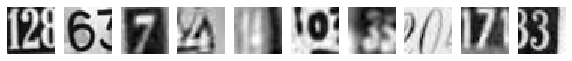

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [133]:
# visualizing the first 10 images in the dataset and their labels
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(32, 32), cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

Here, we define the container NN class that enables the forward prop and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule.

In [0]:
class NN():
    def __init__(self, lossfunc=CrossEntropy(), mode='train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

Defining the update function (SGD with momentum)

In [0]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] - learning_rate * g[i]
            p[i] += v[i]

Defining a function which gives us the minibatches (both the datapoint and the corresponding label)

In [0]:
# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
        
    return minibatches

The traning loop

In [0]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_train1 = []
        y_vall = []
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, : ]
            y_tr = y_train[i:i + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, : ]
            y_va = y_val[i:i + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)

        mean_train_loss = sum(loss_batch) / float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net

Accuracy of the model 

In [0]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

Defining the parameters required

In [0]:
## input size
input_dim = X_train.shape[1]

## hyperparameters
iterations = 10
learning_rate = 0.001
hidden_nodes = 64
output_nodes = 10

## define neural net
nn = NN()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))

In [140]:
#Training the Neural Network with 500 epochs after which the validation accuracy is not increasing much beyond 82%.
nn = train(nn, X_train , y_train, minibatch_size=100, epoch=500, learning_rate=learning_rate, X_val=X_val, y_val=y_val)

Loss = 2.3026254966955904 | Training Accuracy = 0.1034047619047619 | Val Loss = 2.3020450601960682 | Val Accuracy = 0.10466666666666667
Loss = 2.302436589669163 | Training Accuracy = 0.10230952380952381 | Val Loss = 2.3019865311164827 | Val Accuracy = 0.09544444444444444
Loss = 2.3022479566579466 | Training Accuracy = 0.10219047619047619 | Val Loss = 2.3018960127358667 | Val Accuracy = 0.09522222222222222
Loss = 2.3020017949364884 | Training Accuracy = 0.10207142857142858 | Val Loss = 2.301743296911695 | Val Accuracy = 0.09538888888888888
Loss = 2.301656754655882 | Training Accuracy = 0.10221428571428572 | Val Loss = 2.3015703968727195 | Val Accuracy = 0.0956111111111111
Loss = 2.301155327985102 | Training Accuracy = 0.10335714285714286 | Val Loss = 2.301292994391318 | Val Accuracy = 0.0965
Loss = 2.30039443969987 | Training Accuracy = 0.11216666666666666 | Val Loss = 2.3008628145616266 | Val Accuracy = 0.10622222222222222
Loss = 2.299224516266344 | Training Accuracy = 0.13747619047619

Take a single image and showing its prediction

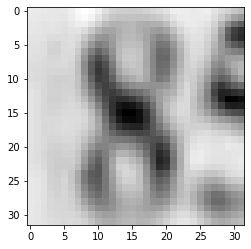

In [141]:
n = 31
plt.imshow(X_val[n].reshape(32,32), cmap='gray')

In [142]:
# Predict Scores for each class
prediction = nn.predict_scores(X_val[n])[0]
print("Scores", prediction)
np.argmax(prediction)

Scores [7.07082104e-13 2.62429654e-10 2.18365240e-08 1.37343015e-03
 1.03378310e-09 3.06276835e-05 4.48641240e-05 4.97750329e-11
 9.98550968e-01 8.71691058e-08]


8

In [143]:
predict_class = nn.predict(X_val[n])[0]
print("Predicted Class:",predict_class)
print("Original Class:", y_val[n])

Predicted Class: 8
Original Class: 8


In [144]:
y_predict = nn.predict(X_val)
cm_NN = confusion_matrix(y_val, y_predict)
print("Confusion Matrix:\n", cm_NN)

Confusion Matrix:
 [[1502   33   16   18   15   11   52   45   26   96]
 [  22 1519   28   39   54   20   25   68   20   33]
 [   8   26 1514   38   25   19    9   75   25   64]
 [  19   34   38 1248   15  185   27   58   46   49]
 [  22   53   31   24 1509   35   54   12   13   59]
 [  11   21   20   68    9 1486   61   17   25   50]
 [  33   27   16   25   29   80 1518   12   67   25]
 [  18   66   48   17    7   22   16 1560    6   48]
 [  26   45   25   45   16   70  141   15 1342   87]
 [  42   29   27   36   20   66   22   37   29 1496]]


In [145]:
precision_NN, recall_NN,fscore_NN,support_NN = metrics.precision_recall_fscore_support(y_val, y_predict, average='weighted')
print("Precision:", precision_NN, "\nRecall:", recall_NN, "\nfScore:", fscore_NN, "\nSupport: " , support_NN)

Precision: 0.8192233207566396 
Recall: 0.8163333333333334 
fScore: 0.8164957714639031 
Support:  None


Based on this exercise it is understood that, with typical machine learning algorithms like K-nearest neighbour it takes lot of time during the test phase which is not good for such models to put in Production.
Whereas the Neural Networks take good amount of time during training to learn the weights, bias etc. However for the test data the prediction is very fast.

#Implementing the above using Keras


In [0]:
model = Sequential()
model.add(Dense(64, input_dim=1024, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation="softmax"))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics =['accuracy'])

In [147]:
model.fit(np.array(X_train),np.array(y_train), epochs=500, batch_size = 200)


Epoch 1/500
42000/42000 [==============================] - 1s 24us/step - loss: 2.2403 - acc: 0.1721
Epoch 2/500
42000/42000 [==============================] - 1s 17us/step - loss: 1.7511 - acc: 0.4218
Epoch 3/500
42000/42000 [==============================] - 1s 17us/step - loss: 1.4422 - acc: 0.5384
Epoch 4/500
42000/42000 [==============================] - 1s 17us/step - loss: 1.3134 - acc: 0.5848
Epoch 5/500
42000/42000 [==============================] - 1s 18us/step - loss: 1.2332 - acc: 0.6145
Epoch 6/500
42000/42000 [==============================] - 1s 18us/step - loss: 1.1696 - acc: 0.6391
Epoch 7/500
42000/42000 [==============================] - 1s 18us/step - loss: 1.1186 - acc: 0.6567
Epoch 8/500
42000/42000 [==============================] - 1s 18us/step - loss: 1.0761 - acc: 0.6718
Epoch 9/500
42000/42000 [==============================] - 1s 19us/step - loss: 1.0438 - acc: 0.6819
Epoch 10/500
42000/42000 [==============================] - 1s 18us/step - loss: 1.0206 - a

In [0]:
y_predict_scores = model.predict(X_val)

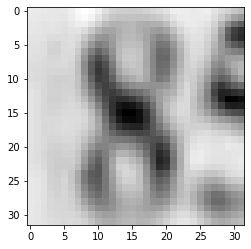

In [149]:
n = 31
plt.imshow(X_val[n].reshape(32,32), cmap='gray')

In [150]:
print("Predicted Class:", y_predict_scores[n].argmax())
print("Original Class:", y_val[n])

Predicted Class: 8
Original Class: 8


In [0]:
#Getting the class value from the prediction scores returned by softmax of final layer in the network.
y_predict = np.argmax(y_predict_scores, axis=1)

In [152]:
#displaying y_predict classes
y_predict

array([0, 7, 2, ..., 7, 9, 2])

In [153]:
#Checking the metrics for classification
cm_Keras = confusion_matrix(y_val, y_predict)
print(cm_Keras)

[[1614   41    9   20   25    5   27   20   17   36]
 [  65 1538   14   45   34    4   17   67   24   20]
 [  41   36 1444   52   24   12   12   98   31   53]
 [  30   35   30 1352   16  103   21   40   62   30]
 [  68   69   30   24 1456   14   44   21   43   43]
 [  29   22   10  106   12 1391   77   16   47   58]
 [  80   25   13   33   26   63 1437   12  113   30]
 [  37   77   55   30   15    6    9 1537   13   29]
 [  52   39   19   70   13   35   95   19 1407   63]
 [ 102   35   20   69   18   38   17   34   44 1427]]


The diagonal values on the confusion matrix numbers are high, hence the majority of the records are predicted correctly.

In [154]:
precision_Keras, recall_Keras,fscore_Keras,support_Keras = metrics.precision_recall_fscore_support(y_val, y_predict, average='weighted')
print("Precision:", precision_Keras, "\nRecall:", recall_Keras, "\nfScore:", fscore_Keras, "\nSupport: " , support_Keras)

Precision: 0.8138356611551999 
Recall: 0.8112777777777778 
fScore: 0.8114577478793138 
Support:  None


#Metrics Comparision:

In [159]:
print("K-Nearest:\nPrecision:", precision_Kmean, "\nRecall:", recall_Kmean, "\nfScore:", fscore_Kmean, "\nSupport: " , support_Kmean)
print()
print("NeuralNetScratch:\nPrecision:", precision_NN, "\nRecall:", recall_NN, "\nfScore:", fscore_NN, "\nSupport: " , support_NN)
print()
print("Keras:\nPrecision:", precision_Keras, "\nRecall:", recall_Keras, "\nfScore:", fscore_Keras, "\nSupport: " , support_Keras)

K-Nearest:
Precision: 0.46726604551888157 
Recall: 0.464 
fScore: 0.4629475447667764 
Support:  None

NeuralNetScratch:
Precision: 0.8192233207566396 
Recall: 0.8163333333333334 
fScore: 0.8164957714639031 
Support:  None

Keras:
Precision: 0.8138356611551999 
Recall: 0.8112777777777778 
fScore: 0.8114577478793138 
Support:  None


Confusion Matrix Comparision:

In [158]:
print("K-Nearest:\n", cm_Kmean)
print()
print("NN from Scratch:\n", cm_NN)
print()
print("Keras:\n", cm_Keras)

K-Nearest:
 [[32  1  1  1  2  2  8  2  4  5]
 [ 0 34  6  3  7  5  2  0  2  2]
 [ 4  3 20  3  3  1  2  5  1  5]
 [ 3  3  2 26  4 11  5  2  5  3]
 [ 0  4  3  1 19  1  1  0  3  2]
 [ 3  3  1 10  2 15  5  1 10  2]
 [ 6  4  1  2  1  1 21  1  4  1]
 [ 0  7  4  2  0  1  1 21  1  1]
 [ 0  2  0  3  1  6  8  2 22  5]
 [13  2  2  1  3  3  4  2  3 22]]

NN from Scratch:
 [[1502   33   16   18   15   11   52   45   26   96]
 [  22 1519   28   39   54   20   25   68   20   33]
 [   8   26 1514   38   25   19    9   75   25   64]
 [  19   34   38 1248   15  185   27   58   46   49]
 [  22   53   31   24 1509   35   54   12   13   59]
 [  11   21   20   68    9 1486   61   17   25   50]
 [  33   27   16   25   29   80 1518   12   67   25]
 [  18   66   48   17    7   22   16 1560    6   48]
 [  26   45   25   45   16   70  141   15 1342   87]
 [  42   29   27   36   20   66   22   37   29 1496]]

Keras:
 [[1614   41    9   20   25    5   27   20   17   36]
 [  65 1538   14   45   34    4   17   67   2

Based on the metrics it is evident that Neural networks performs very well for the Image Classifications.